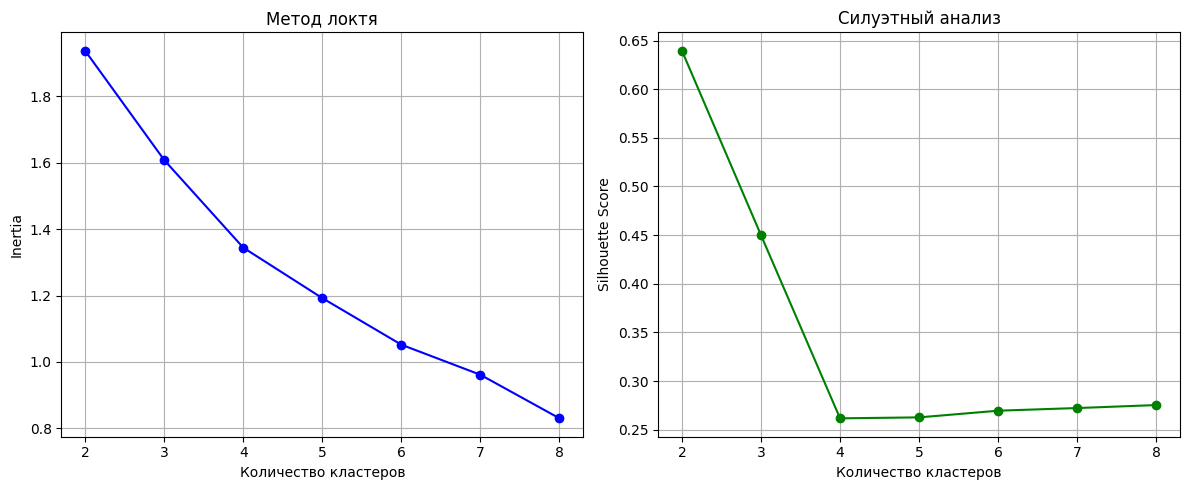

Fitting 5 folds for each of 30 candidates, totalling 150 fits


g:\TMM\Repo\TMO\EXAM\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


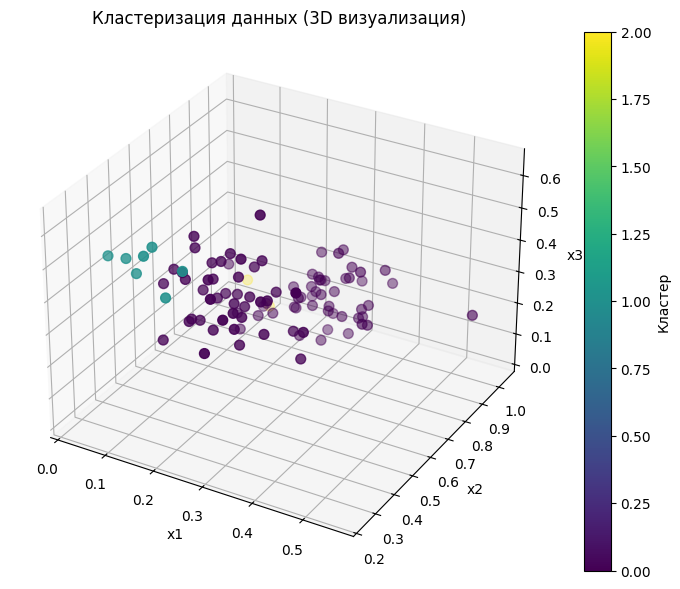

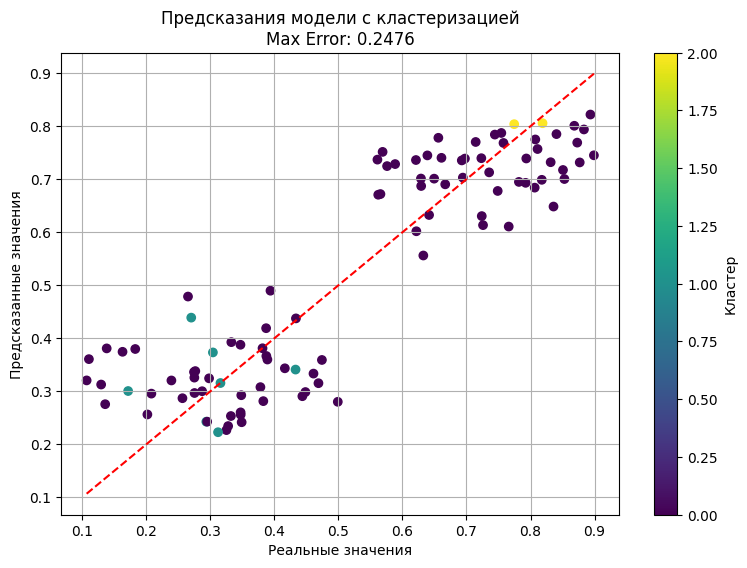

Лучшие параметры: {'cluster__add_distances': True, 'cluster__n_clusters': 2, 'regressor__alpha': 0.001}
Усредненная максимальная ошибка: 0.247614
Модель не достигла целевого порога 0.22


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.base import BaseEstimator, TransformerMixin

# Кастомный трансформер для кластеризации
class ClusterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, add_distances=True):
        self.n_clusters = n_clusters
        self.add_distances = add_distances
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=9)
    
    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self
    
    def transform(self, X, y=None):
        clusters = self.kmeans.predict(X)
        result = np.column_stack([X, clusters])
        
        if self.add_distances:
            distances = self.kmeans.transform(X)
            result = np.column_stack([result, distances])
        
        return result

# Загрузка данных
data = pd.read_csv('dataset_01.csv', sep=';')
X = data[['x1', 'x2', 'x3']]
y = data['y']

# Визуализация данных для определения оптимального числа кластеров
plt.figure(figsize=(12, 5))

# Метод локтя
inertia = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=9)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.subplot(1, 2, 1)
plt.plot(range(2, 9), inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя')
plt.grid(True)

# Силуэтный анализ
silhouette = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=9)
    preds = kmeans.fit_predict(X)
    silhouette.append(silhouette_score(X, preds))

plt.subplot(1, 2, 2)
plt.plot(range(2, 9), silhouette, 'go-')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Силуэтный анализ')
plt.grid(True)

plt.tight_layout()
plt.show()

# Создание пайплайна с кластеризацией
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('cluster', ClusterFeatures(n_clusters=3)),
    ('regressor', Ridge(alpha=0.1))
])

# Параметры для оптимизации
param_grid = {
    'cluster__n_clusters': [2, 3, 4],
    'cluster__add_distances': [True, False],
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 9]
}

# Поиск лучших параметров
grid = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='neg_max_error',
    n_jobs=-1,
    verbose=1
)
grid.fit(X, y)

# Лучшая модель
best_model = grid.best_estimator_
best_params = grid.best_params_

# Оценка качества
scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_max_error')
mean_max_error = np.mean(np.abs(scores))

# Визуализация результатов кластеризации
best_model.fit(X, y)
cluster_transformer = best_model.named_steps['cluster']
clusters = cluster_transformer.kmeans.predict(X)

plt.figure(figsize=(9, 7))
ax = plt.axes(projection='3d')
scatter = ax.scatter(X['x1'], X['x2'], X['x3'], c=clusters, cmap='viridis', s=50)
plt.colorbar(scatter, label='Кластер')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
plt.title('Кластеризация данных (3D визуализация)')
plt.show()

# Визуализация предсказаний
y_pred = best_model.predict(X)
plt.figure(figsize=(9, 6))
plt.scatter(y, y_pred, c=clusters, cmap='viridis')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title(f'Предсказания модели с кластеризацией\nMax Error: {mean_max_error:.4f}')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.colorbar(label='Кластер')
plt.grid(True)
plt.show()

# Вывод результатов
print(f"Лучшие параметры: {best_params}")
print(f"Усредненная максимальная ошибка: {mean_max_error:.6f}")

if mean_max_error <= 0.22:
    print("Модель удовлетворяет условию задачи!")
else:
    print("Модель не достигла целевого порога 0.22")